_Version log: Branch of V9. Trying to apply a 2DFFT insted of a 1DFFT_

In [11]:
import sys
from sklearn.linear_model import Lasso #I'm using scikit insted of svxpy to solve.
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as spimg
from scipy import fft as spfft, linalg as spla
from PIL import Image #I prefer Pillow to imageio
from tqdm import tqdm
np.set_printoptions(threshold=sys.maxsize)

To turn a sparce signal $X$ into the full image $Y$. The L1 norm of,
\begin{equation}
    \mathcal{F} (Y),
\end{equation}
needs to be minimised while also minimising the L2 norm of,
\begin{equation}
    C \times \mathcal{F}^{-1} (I) \times \mathcal{F} (Y) - X,
\end{equation}
where $\mathcal{F}( )$ is the DCT, $I$ is an identerty matrix and $C$ is a cropping transformation matrix such that,
\begin{equation}
    C \times Y = X.
\end{equation}
The weighting between the first two equation can be changed using the regularisation coeffient, $\alpha$. Altogether the function that needs to be minimised looks like,
\begin{equation}
    ||C \times \mathcal{F}^{-1} (I) \times \mathcal{F} (Y) - X||_{2} + \alpha ||\mathcal{F} (Y)||_{1},
\end{equation}
which can be re-writtern in terms of the measurement matrix $A$ and $\mathcal{F} (Y) = Z$ as,
\begin{equation}
    ||A \times Z - X||_{2} + \alpha ||Z||_{1}.
\end{equation}

In [12]:
def open_compressed_image(file_name, file_type, compression):
    if file_type == ".png" or file_type == ".jpg":
        img = Image.open("data\\" + file_name + file_type) # read image
        img = np.array(img).sum(axis=2) # make image grayscale
        array = spimg.zoom(img, compression) # scipy ndimage.zoom compresses (or interpolates) an image.
    elif file_type == ".csv":
        with open("data\\" + file_name + file_type, 'r') as file: #openai did this bit for me. It automatically detects which delimiter to use (pyro uses , xeva uses ;)
            first_line = file.readline()
            if ';' in first_line:
                delimiter = ';'
            else:
                delimiter = ','
        img = np.loadtxt("data\\" + file_name + file_type, delimiter=delimiter)
        array = spimg.zoom(img, compression, mode= "nearest") # scipy ndimage.zoom compresses (or interpolates) an image.
    else:
        raise ValueError("{0:} is not a regonised file type.".format(file_type))
    return array, img

def subsample_2d(array, subsampling_percentage = 0.5, subsampling_method = "random"):
    
    array_flat = array.flatten()
    total_points = np.multiply(*array.shape)
    total_rows, total_columns = array.shape
    print(array.shape)


    if subsampling_method == "random":
        reduced_points = round(total_points *subsampling_percentage)
        subsampled_points = np.random.choice(total_points, reduced_points, replace= False)
    if subsampling_method == "random_columns":
        reduced_columns = round(total_columns *subsampling_percentage)
        subsampled_columns = np.random.choice(total_columns, reduced_columns, replace= False)
        subsampled_points = [subsampled_columns + row_number*total_columns for row_number in range(total_rows)]
        subsampled_points = np.array(subsampled_points).flatten()
    if subsampling_method == "random_rows":
        reduced_rows = round(total_rows *subsampling_percentage)
        subsampled_rows = np.random.choice(total_rows, reduced_rows, replace= False)
        subsampled_points = [column_number + subsampled_rows*total_columns for column_number in range(total_columns)]
        subsampled_points = np.array(subsampled_points).flatten()

    if subsampling_method == "regular_columns":
        reduced_columns = round(total_columns *subsampling_percentage)
        subsampled_columns = np.round(np.linspace(0, total_columns -1, reduced_columns)).astype(int)
        subsampled_points = [subsampled_columns + row_number*total_columns for row_number in range(total_rows)]
        subsampled_points = np.array(subsampled_points).flatten()
    if subsampling_method == "regular_rows":
        reduced_rows = round(total_rows *subsampling_percentage)
        subsampled_rows = np.round(np.linspace(0, total_rows -1, reduced_rows)).astype(int)
        subsampled_points = [column_number + subsampled_rows*total_columns for column_number in range(total_columns)]
        subsampled_points = np.array(subsampled_points).flatten()
    if subsampling_method == "regular_grid":
        reduced_columns = round(total_columns *subsampling_percentage**0.5)
        subsampled_columns = np.round(np.linspace(0, total_columns -1, reduced_columns)).astype(int)
        reduced_rows = round(total_rows *subsampling_percentage**0.5)
        subsampled_rows = np.round(np.linspace(0, total_rows -1, reduced_rows)).astype(int)
        subsampled_points = [subsampled_columns + row_number*total_columns for row_number in subsampled_rows]
        subsampled_points = np.array(subsampled_points).flatten()

    if subsampling_method == "hadamard":
        #############IGNORES SUBSAMPLING PERCENTAGE!!!!!!################
        hadamard_size = 2**np.ceil(np.log2(np.max(array.shape))) # Make a hadamard matrix that overfills the image. The size must be a power of 2.
        hadamard_matrix = spla.hadamard(hadamard_size)
        hadamard_matrix = hadamard_matrix[:total_rows, :total_columns] #crop it to the same size as the image
        hadamard_matrix = hadamard_matrix.flatten()
        subsampled_points = np.argwhere(hadamard_matrix == 1).flatten()


    subsampled_points = np.sort(subsampled_points) #Not nessisary but makes it easier to look at.
    signal_flat = np.full(total_points, np.nan)
    signal_flat[subsampled_points] = array_flat[subsampled_points]
    signal_sparce = array_flat[subsampled_points]
    signal = np.reshape(signal_flat, array.shape)

    return signal, signal_flat, signal_sparce, subsampled_points

def Coeffients2Amplitudes(FT, freqs): #stolen from interferogram analysis
    samples = len(FT)
    num_of_freqs = len(FT)//2 +1
    amplitude = np.zeros(num_of_freqs)
    amplitude[0] = np.abs(FT[0])
    if (samples//2 == samples/2): #if even
        amplitude[-1] = np.abs(FT[num_of_freqs-1])
        amplitude[1:-1] = (np.abs( FT[1:num_of_freqs-1] ) +
                            np.abs( FT[:num_of_freqs-1:-1] ))

        freqs = freqs[:num_of_freqs]
        freqs[-1] = -freqs[-1] #The niquist freqency is considered to be negative by np.fft.fftfreq(). This should make it positive.
        wavelengths = 1/freqs
    else: #if odd
        amplitude[1:] = (np.abs( FT[1:num_of_freqs] ) +
                        np.abs( FT[:num_of_freqs-1:-1] ))
        
        freqs = freqs[:num_of_freqs]
        wavelengths = 1/freqs
    return amplitude, wavelengths, freqs

(147, 147)


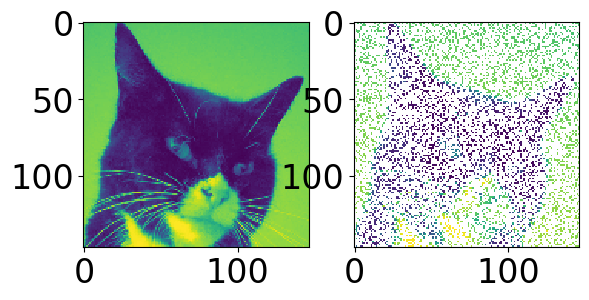

In [13]:
file_name = "alfie"
file_type = ".png"
compression = 0.2 #fraction of the image to keep (The image is too large to process quickly)
subsample_percentage = 0.25 #fraction of the image to subsample
subsampling_method= "random" #"random" "random_columns" "random_rows" "regular_grid" "regular_columns" "regular_rows" "hadamard"

# original image
target, img = open_compressed_image(file_name, file_type, compression)
total_points = np.multiply(*target.shape)

signal, signal_flat, signal_sparce, random_points_1d = subsample_2d(target, subsampling_method= subsampling_method, subsampling_percentage= subsample_percentage)
random_points_2d = np.argwhere(~np.isnan(signal))

fig, axs = plt.subplots(1,2)

axs[0].imshow(target, interpolation= "nearest")
axs[1].imshow(signal, interpolation= "nearest")

plt.show()

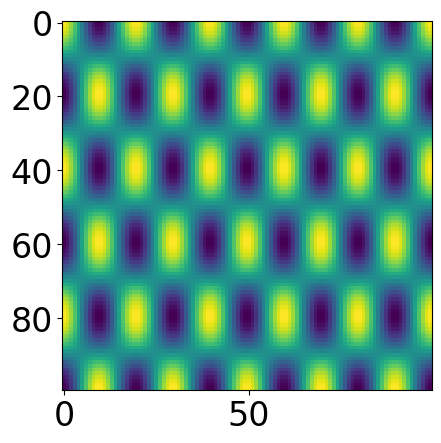

In [14]:
a = np.zeros([100,100])
a[5,10] = 1.
b = spfft.idctn(a)

plt.imshow(b)
plt.show()

In [15]:
reduced_points = len(random_points_1d)

#measurement_matrix = np.zeros([reduced_points, total_points], dtype= np.float16) #No longer needed
#for n, random_point in enumerate(random_points_1d):
#    measurement_matrix[n, random_point] = 1.


transformation_matrix = np.zeros([reduced_points, *signal.shape], dtype= np.float64) #scikit uses np.float64 # [x&y, k_x, k_y]
for n in tqdm(range(signal.shape[0])):
    for m in range(signal.shape[1]):
        frequency_vector = np.zeros(signal.shape) #frequency_vector is a slice of the identerty matrix. It represents one frequency.
        frequency_vector[n, m] = 1.
        frequency_vector = spfft.idctn(frequency_vector)
        transformation_matrix[:, n, m] = frequency_vector.flatten()[random_points_1d]

print(transformation_matrix.shape)

#fig, axs = plt.subplots(1,1)

#axs[0].imshow(measurement_matrix, interpolation= "nearest") #some images are too big to plot!
#axs.imshow(transformation_matrix[30], interpolation= "nearest")

#plt.show()

100%|██████████| 147/147 [00:04<00:00, 35.64it/s]

(5402, 147, 147)


In [16]:
transformation_matrix = transformation_matrix.reshape(reduced_points, total_points)
print(transformation_matrix.shape)

(5402, 21609)


In [21]:
regularization_coeffient = 1e-6 #DECREASE FOR COMPLEX IMAGES (up to 1e-7 (floating point error?)) INCREASE FOR SIMPLE IMAGES (up to 1e-2)

lasso = Lasso(alpha=regularization_coeffient)
lasso.fit(transformation_matrix, signal_sparce)
result_DCT_flat = lasso.coef_

print(result_DCT_flat.shape)
print(total_points)

(21609,)
21609


In [22]:
result_DCT = result_DCT_flat.reshape(signal.shape)
result = spfft.idctn(result_DCT)

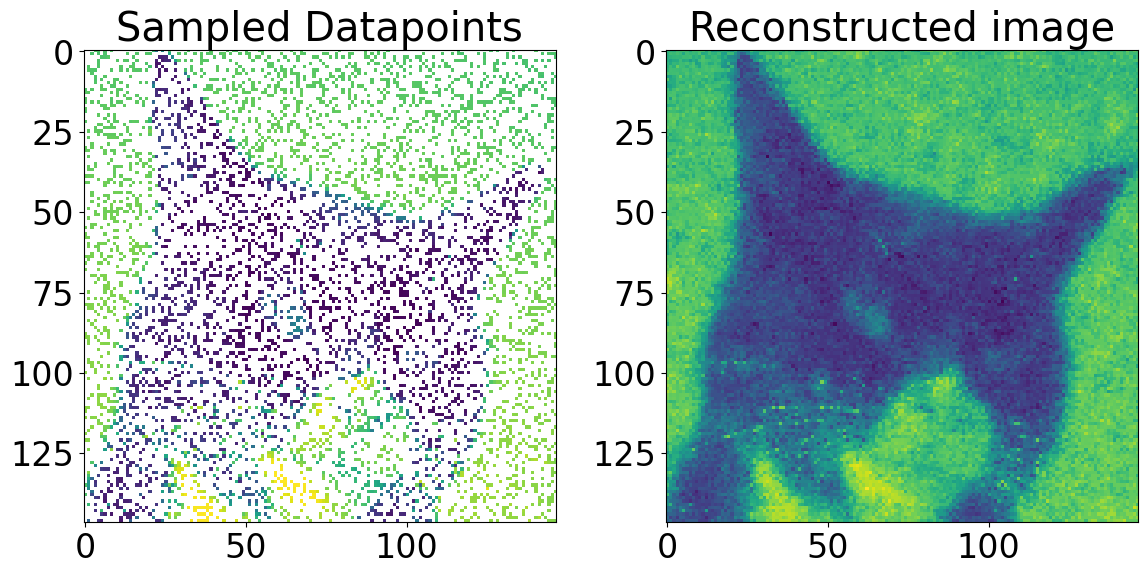

In [23]:
plt.rcParams.update({"font.size":24})

fig, axs = plt.subplots(1,2, figsize= (12,8))

axs[0].imshow(signal, interpolation = "nearest")
axs[0].set_title("Sampled Datapoints")
axs[1].imshow(result, interpolation = "nearest")
axs[1].set_title("Reconstructed image")

plt.tight_layout()
plt.savefig("graphs\\alfie_test11")

plt.show()

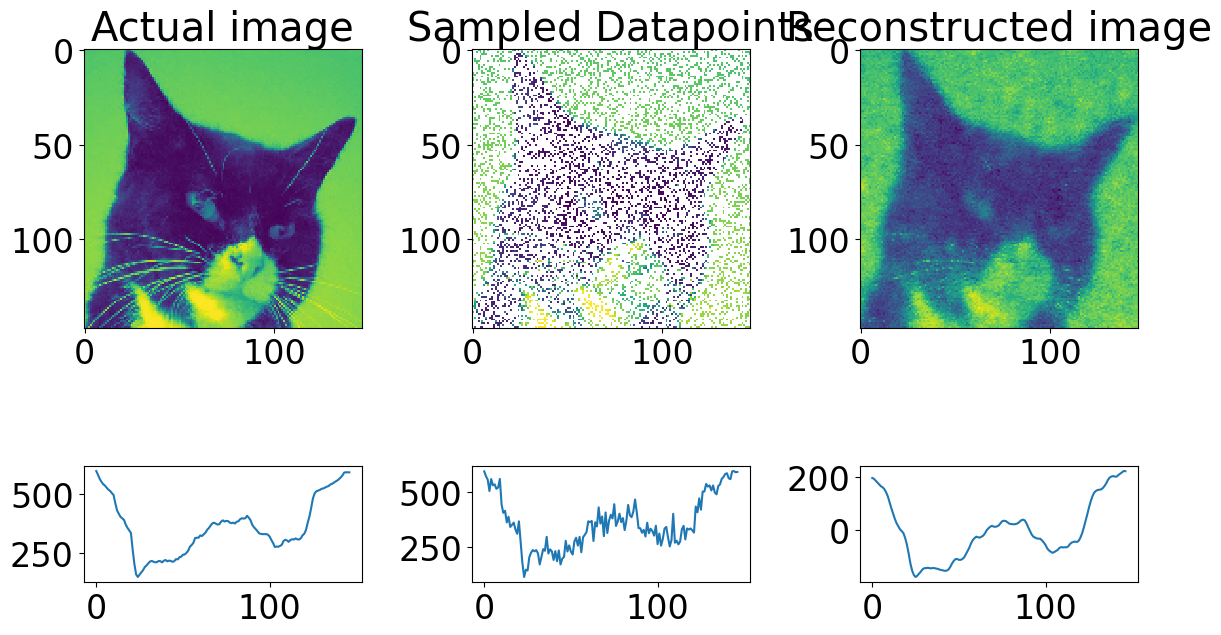

In [20]:
fig, axs = plt.subplots(2,3, figsize= (12,8), height_ratios= [1, 0.2])

axs[0][0].imshow(target, interpolation = "nearest")
axs[0][0].set_title("Actual image")
axs[0][1].imshow(signal, interpolation = "nearest")
axs[0][1].set_title("Sampled Datapoints")
axs[0][2].imshow(result, interpolation = "nearest")
axs[0][2].set_title("Reconstructed image")

axs[1][0].plot(np.nanmean(target, axis= 0))
axs[1][1].plot(np.nanmean(signal, axis= 0))
axs[1][2].plot(np.nanmean(result, axis= 0))

plt.tight_layout()
plt.show()